# Cultural Network Simulation COVID-19 2020: Using Mesa to do agent based modeling

This version has been updated Apr 2020

SEIR model: susceptible (S), infectious (I), recovered (R), and individual can be exposed (E)
We are modeling how a COVID spreads over a population (network)

beta ( β ): probability susceptible-infected contact results in a new exposure <br>
gamma ( γ ): probability infected recovers<br>
sigma ( σ ) or alpha ( α ): probability exposed person becomes infected

Written by Tim Hannigan, adapted from Mesa/NetLogo model "Virus on Network".
https://github.com/projectmesa/mesa/tree/master/examples/virus_on_network

In [36]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid
from mesa.batchrunner import BatchRunner

import operator
import igraph
import pandas as pd
import matplotlib.pyplot as plt
import random
import enum
import math
import numpy as np
import networkx as nx
from random import randint
import scipy.stats as st

## Class methods

In [89]:
class State(enum.Enum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    RESISTANT = 2
    DECEASED = 3

class CulturalOrientation(enum.Enum):
    INTERACTOR = 0
    CONNECTOR = 1
    DIVIDER = 2
    AVOIDER = 3


class Contagion_spill_over_risk(enum.Enum):
    HIGH = 0.5
    MEDIUM = 0.25
    LOW = 0.1
    VERY_LOW = 0
    
def number_state(model, state):
     return sum([1 for actor_id,actor in model.grid.items() if actor.state is state])

def number_infected(model):
    return number_state(model, State.INFECTED)

def number_susceptible(model):
    return number_state(model, State.SUSCEPTIBLE)

def number_resistant(model):
    return number_state(model, State.RESISTANT)

def number_infectious(model):
    return number_state(model, State.INFECTIOUS)

def number_deceased(model):
    return number_state(model, State.DECEASED)




# TO DO:
# capture deaths

class SocialSetting(Model):
    """A model with some number of agents"""
    def __init__(self, graph=None, initial_outbreak_size=1, sigma=0.8, gamma=0.3, mu=0.02, recovery_chance=0.75,gain_resistance_chance=0.1):
        num_nodes = len(graph.vs)
        self.num_nodes = num_nodes
        self.G = graph
        self.grid = {} # managing the agents as a dict 
        self.schedule = RandomActivation(self)
        self.initial_outbreak_size = initial_outbreak_size if initial_outbreak_size <= num_nodes else num_nodes
        self.sigma = sigma
        self.gamma = gamma # recovery_chance
        self.mu = mu # death rate
        self.gain_resistance_chance = gain_resistance_chance
        self.day=0
        self.recovery_chance = recovery_chance
        self.gain_resistance_chance = 0
        self.datacollector = DataCollector({"Infected": number_infected,
                                            "Susceptible": number_susceptible,
                                            "Resistant": number_resistant,
                                            "Deceased": number_deceased})
         # Create agents
        for v in self.G.vs:
            a = SocialAgent(v.index, self, State.SUSCEPTIBLE,
                           self.recovery_chance, self.gain_resistance_chance, int(v['cultural_orientation']) )
            self.schedule.add(a)
            # Add agent to the grid
            self.grid[v.index]=a 

         # Infect some agents randomly as an initial state        
        infected_nodes = random.sample(list(self.G.vs), self.initial_outbreak_size)
        for v in infected_nodes:            
            self.grid[v.index].state = State.INFECTED

        self.running = True
        self.datacollector.collect(self)
        
    # TO DO
    #def resistant_susceptible_ratio(self):
    #    try:
    #        return number_state(self, State.RESISTANT) / number_state(self, State.SUSCEPTIBLE)
    #    except ZeroDivisionError:
    #        return math.inf

    def step(self):
        self.day+=1
        self.susceptible_agents_dying()        
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)
        #print ("day:",self.day, " number_infected:",number_infected(model), " number_susceptible:", number_susceptible(model))

    def run_model(self, n):
        for i in range(n):
            self.step()

    def check_grid(self):# check data structure            
        for id, actor in self.grid.items():
            print (actor.unique_id, actor.state, actor.cultural_orientation)
            
    def susceptible_agents_dying(self):
        # using Verity et al 2020 Lancet article, mean time to death is 17.8 days, with fatality rate as 1.38%, recovery as 24.7 days
        # in this model, how can we get the mean time to death accurately depicted? Assuming normal distribution
        set_of_actors_facing_fatality = []
        for id, actor in self.grid.items():
            #print (actor.unique_id, actor.state, actor.cultural_orientation)
            days_since_actor_infected =  self.day - actor.day_infected
            if actor.state is State.INFECTED and days_since_actor_infected>=11 and days_since_actor_infected<=25: set_of_actors_facing_fatality.append(actor)
        # now that we have set_of_actors_facing_fatality, the fatality rate (mu) will be applied to this; assumption is that this is an overall rate per day
        
        # assuming distribution in hazard rate; closeness to 17.8 days; 7 days of equal hazard proportions
        hazard_dict = {} # order by values later
        for actor in set_of_actors_facing_fatality:
            days_since_actor_infected =  self.day - actor.day_infected            
            hazard_abs = abs(18 - days_since_actor_infected) # absolute value will range between 7 (min) and 0 (max)
            hazard_abs_standardized = abs(7-hazard_abs)
            # 7 units, each equally hazardous; more units, more risk for an actor            
            hazard_percentage = hazard_abs_standardized/7 # find the inverse, then express as a percentage, so that the hazard is highest the closest to day 18
            hazard_dict[actor.unique_id]=round(hazard_percentage,2)            
            # A more straight-forward approach: I could calculate this with probabilities using normDist and z-scores
            #p = st.norm.cdf(x=days_since_actor_infected,loc=17.8,scale=3.45)
            #z_score = st.norm.ppf(p)
        ids_sorted_by_hazard = dict(sorted(hazard_dict.items(), key=operator.itemgetter(1),reverse=True))
        #print("day:", self.day, "ids_sorted_by_hazard:", ids_sorted_by_hazard)
        
        if len(set_of_actors_facing_fatality)>0:
            standardized_unit = round(100/len(set_of_actors_facing_fatality))
            #print ("standardized_unit:", standardized_unit)
            hazards_proportioned = [-1]*101
            i=0
            for actor_id, hazard_proportion in hazard_dict.items():
                units_for_actor= round(standardized_unit*hazard_proportion)            
                for j in range(0,units_for_actor): 
                    hazards_proportioned[i+j] = actor_id
                i+=units_for_actor
            #print ("hazards_proportioned:", hazards_proportioned)    

            # assign fatalities: based on selection from list and mu (fatality rate)
            len_set_of_actors_facing_fatality = len(set_of_actors_facing_fatality)        
            #should hazard be organized by closeness to 17.8 days?         
            number_of_fatalities_on_day = math.floor(len_set_of_actors_facing_fatality * self.mu) # rounding-down,is this correct?        
            self.random.random() < self.mu
            for i in range(0,number_of_fatalities_on_day):
                # select from hazards_proportioned list
                fatal_actor_id = hazards_proportioned[randint(0,100)]
                if fatal_actor_id>0: #if found a match
                    print("actor deceased", fatal_actor_id)
                    patient_deceased = self.grid[int(fatal_actor_id)]
                    patient_deceased.state = State.DECEASED
            
    ##def infected_agents_recovering(self):
        # actors recover after 25 days (if not deceased)
        for id, actor in self.grid.items():
            days_since_actor_infected =  self.day - actor.day_infected
            if actor.state is State.INFECTED and days_since_actor_infected>=25: actor.state = State.RESISTANT
            
    def save_graph(self, filename="graph_output.graphml"):
        self.G.vs['state'] = ""
        self.G.vs['cultural_orientation'] = ""        
        for v in self.G.vs:
            self.G.vs[v.index]['state'] = self.grid[v.index].state.name
            self.G.vs[v.index]['cultural_orientation'] = self.grid[v.index].cultural_orientation.name
        self.G.write_graphml(filename)

In [103]:
class SocialAgent(Agent):
    def __init__(self, unique_id, model, initial_state,
                 recovery_chance, gain_resistance_chance, cultural_orientation):
        super().__init__(unique_id, model)
        self.state = initial_state
        self.recovery_chance = recovery_chance # this is a property of individual
        self.gain_resistance_chance = gain_resistance_chance
        self.day_infected = 0
        self.died = False
        # cultural orientation: compassionate, concerned, stigmatizing, avoiding
        self.cultural_orientation = CulturalOrientation(cultural_orientation)

        
    def try_to_infect_neighbors(self):
        neighbors_nodes = self.model.G.neighbors(self.unique_id)
        susceptible_neighbors = [] # this is purely the sigma rate (probability exposed person becomes infected)
        # rolling the dice, infection rates based sender's cultural orientation
        if self.cultural_orientation is CulturalOrientation.INTERACTOR: # engager
            number_of_neighbors_to_infect = randint(1,4) # max 4
        elif self.cultural_orientation is CulturalOrientation.CONNECTOR: # linker
            number_of_neighbors_to_infect = randint(1,3) # max 3
        elif self.cultural_orientation is CulturalOrientation.DIVIDER: # avoider
            number_of_neighbors_to_infect = randint(1,2) # max 2
        elif self.cultural_orientation is CulturalOrientation.AVOIDER: # loner
            number_of_neighbors_to_infect = 1 # max 1
        neighbors_nodes_permutation = np.random.permutation(neighbors_nodes)[number_of_neighbors_to_infect:]
        for neighbor_node_id in neighbors_nodes_permutation: # need to code for combinations of orientations (in the table)
            agent_receiver = self.model.grid[neighbor_node_id]
            if agent_receiver.state is State.SUSCEPTIBLE: # only do this if the receiver is not yet infected               
                ### 
                # running through the 4 conditions of the sender
                # using the following thresholds:
                # High: 0.5
                # Medium: 0.25
                # Low: 0.1
                # However, as this is a network model, we are adding the two probabilities together (sender + receiver)
                ###
                # first condition: sender is interactor
                if self.cultural_orientation is CulturalOrientation.INTERACTOR:
                    sender_probability = Contagion_spill_over_risk.HIGH.value                    
                    if agent_receiver.cultural_orientation is CulturalOrientation.INTERACTOR:                         
                        receiver_probability = Contagion_spill_over_risk.HIGH.value                    
                    elif agent_receiver.cultural_orientation is CulturalOrientation.CONNECTOR:                         
                        receiver_probability = Contagion_spill_over_risk.HIGH.value                    
                    elif agent_receiver.cultural_orientation is CulturalOrientation.DIVIDER:                         
                        receiver_probability = Contagion_spill_over_risk.MEDIUM.value                    
                    elif agent_receiver.cultural_orientation is CulturalOrientation.AVOIDER: # note: a tie between these still indicates risk                                                
                        receiver_probability = Contagion_spill_over_risk.VERY_LOW.value                    
                    beta_enumerated =  sender_probability +  receiver_probability
                    if self.random.random() < beta_enumerated: susceptible_neighbors.append(agent_receiver)    
                # second condition: sender is connector
                elif self.cultural_orientation is CulturalOrientation.CONNECTOR:
                    sender_probability = Contagion_spill_over_risk.HIGH.value                    
                    if agent_receiver.cultural_orientation is CulturalOrientation.INTERACTOR:                         
                        receiver_probability = Contagion_spill_over_risk.HIGH.value                    
                    elif agent_receiver.cultural_orientation is CulturalOrientation.CONNECTOR:                         
                        receiver_probability = Contagion_spill_over_risk.HIGH.value                    
                    elif agent_receiver.cultural_orientation is CulturalOrientation.DIVIDER:                         
                        receiver_probability = Contagion_spill_over_risk.LOW.value                    
                    elif agent_receiver.cultural_orientation is CulturalOrientation.AVOIDER: # need to double-check this with team
                        sender_probability = Contagion_spill_over_risk.LOW.value                    
                        receiver_probability = Contagion_spill_over_risk.MEDIUM.value                    
                    beta_enumerated =  sender_probability +  receiver_probability
                    if self.random.random() < beta_enumerated: susceptible_neighbors.append(agent_receiver)    
                # third condition: sender is divider
                elif self.cultural_orientation is CulturalOrientation.DIVIDER:                    
                    if agent_receiver.cultural_orientation is CulturalOrientation.INTERACTOR:                         
                        sender_probability = Contagion_spill_over_risk.MEDIUM.value                    
                        receiver_probability = Contagion_spill_over_risk.HIGH.value                    
                    elif agent_receiver.cultural_orientation is CulturalOrientation.CONNECTOR:         
                        sender_probability = Contagion_spill_over_risk.MEDIUM.value                    
                        receiver_probability = Contagion_spill_over_risk.HIGH.value                    
                    elif agent_receiver.cultural_orientation is CulturalOrientation.DIVIDER:                         
                        sender_probability = Contagion_spill_over_risk.MEDIUM.value                    
                        receiver_probability = Contagion_spill_over_risk.MEDIUM.value                        
                    elif agent_receiver.cultural_orientation is CulturalOrientation.AVOIDER: # need to double-check this with team
                        sender_probability = Contagion_spill_over_risk.LOW.value                    
                        receiver_probability = Contagion_spill_over_risk.VERY_LOW.value                    
                    beta_enumerated =  sender_probability +  receiver_probability
                    if self.random.random() < beta_enumerated: susceptible_neighbors.append(agent_receiver)    
                # fourth condition: sender is avoider
                elif self.cultural_orientation is CulturalOrientation.AVOIDER:                    
                    if agent_receiver.cultural_orientation is CulturalOrientation.INTERACTOR:                         
                        sender_probability = Contagion_spill_over_risk.VERY_LOW.value                    
                        receiver_probability = Contagion_spill_over_risk.HIGH.value                    
                    elif agent_receiver.cultural_orientation is CulturalOrientation.CONNECTOR:         
                        sender_probability = Contagion_spill_over_risk.VERY_LOW.value                    
                        receiver_probability = Contagion_spill_over_risk.HIGH.value                    
                    elif agent_receiver.cultural_orientation is CulturalOrientation.DIVIDER:                         
                        sender_probability = Contagion_spill_over_risk.VERY_LOW.value                    
                        receiver_probability = Contagion_spill_over_risk.MEDIUM.value                        
                    elif agent_receiver.cultural_orientation is CulturalOrientation.AVOIDER: # need to double-check this with team
                        sender_probability = Contagion_spill_over_risk.VERY_LOW.value                    
                        receiver_probability = Contagion_spill_over_risk.VERY_LOW.value                    
                    beta_enumerated =  sender_probability +  receiver_probability
                    if self.random.random() < beta_enumerated: susceptible_neighbors.append(agent_receiver)    
        # for receivers who are susceptable by virtue of the sender/receiver cultural orientations, 
        for a in susceptible_neighbors:
            if self.random.random() < self.model.sigma:
                a.state = State.INFECTED
                a.day_infected = self.model.day

    #     def try_gain_resistance(self):
    #         if self.random.random() < self.gain_resistance_chance:
    #             self.state = State.RESISTANT

    def try_remove_infection(self):
        if (self.model.day - self.day_infected) >= 25: # Assuming 25 day recovery
            
            agent_recovery_chances = self.recovery_chance # baseline
            for neighbor_node_id in self.model.G.neighbors(self.unique_id):
                if self.model.grid[neighbor_node_id] is CulturalOrientation.INTERACTOR: 
                    # for every INTERACTOR they are connected today, increase their recovery chances beyond baseline by 5%
                    agent_recovery_chances+=.05            
            if self.random.random() < agent_recovery_chances: 
                # Success            
                self.state = State.RESISTANT
            else: # Failed
                self.state = State.INFECTED
        else:
            # Failed
            self.state = State.INFECTED            

    def step(self):
        if self.state is State.INFECTED:
            self.try_to_infect_neighbors()
            self.try_remove_infection()
        

## Helper methods

Write any helper methods here

## First step, establish network at t=0

### Using NetworkX to generate desired networks

#### Interactive_communities

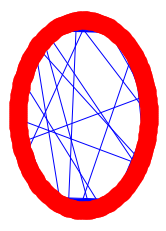

In [236]:
# using https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.generators.community.relaxed_caveman_graph.html
g = nx.relaxed_caveman_graph(6, 25, 0.0175, seed=42) # 6 cliques, size for each clique is 25, Probabilty of rewiring each edge.
hc_nodes = nx.harmonic_centrality(g) # using Boldi, Paolo, and Sebastiano Vigna. “Axioms for centrality.” Internet Mathematics 10.3-4 (2014): 222-262.
# Harmonic centrality 1 of a node u is the sum of the reciprocal of the shortest path distances from all other nodes to u
nx.set_node_attributes(g, hc_nodes, 'harmonic_centrality')
nx.write_graphml(g, "interactive_communities.graphml")  
plt.subplot(121)
nx.draw(g, pos=nx.circular_layout(g), node_color='r', edge_color='b')

In [312]:
# now determine modularity using iGraph
g = igraph.Graph.Read_GraphML("interactive_communities.graphml")
#g.summary()


# compute community detection using iGraph
community = g.community_multilevel() # using Louvain method (https://en.wikipedia.org/wiki/Louvain_modularity), VD Blondel, J-L Guillaume, R Lambiotte and E Lefebvre: Fast unfolding of community hierarchies in large networks, J Stat Mech P10008 (2008), http://arxiv.org/abs/0803.0476
#community 

#print(community)

# assign modularity class
g.vs['community_membership'] = 0 # default

g.vs['cultural_orientation'] = "" # default 
### For interactive community, proportions should be:
#LINKER (connector) - 20 % 5 nodes
#ENGAGER(interactor) - 40 % 10 nodes
#DIVIDER (divider) - 30 % 8 nodes
#LONER (avoider) - 10 % 2 nodes

### For isolative community, proportions should be:
#LINKER (connector) - 10 %
#ENGAGER(interactor) - 30 %
#DIVIDER (divider) - 40 %
#LONER (avoider) - 20 %


comm_id= 0 # start with community 0
for comm in community: # iterate through communities to determine membership
    for node_id in comm:
        g.vs[node_id]['community_membership'] = comm_id
    comm_id+=1

connector_counts = []
interactor_counts = []
divider_counts = []
isolator_counts = []

####### Perhaps leave this for now with pure types
## Randomly select a community to be a gated community, where there are only two ways in
#gated_community = randint(len(community))
# first, will take a survey of all linker ties, and then only keep 2 of them

comm_id= 0 # start with community 0
# iterate through communities to rewire for isolates and divider
for comm in community: #[community[0]]: # iterate through communities 
    #print("\n\ncommunity:", comm_id)
    #print("first pass, linkers")    
    ########################
    ## first pass, creating connectors/linkers nodes
    ########################    
    potential_connector_nodes = []
    # these are defined as having connections to other clusters
    for node_id in comm:
        for neighbor_node in g.vs[node_id].neighbors(): 
            if neighbor_node['community_membership'] is not comm_id:
                potential_connector_nodes.append(node_id)
                g.vs[node_id]['cultural_orientation'] = "LINKER"
                break        
                #more ties out than in 
    connector_counts.append(len(potential_connector_nodes))    
    # process these nodes
    for node_id in potential_connector_nodes:
        desired_ties_into_clique = randint(2,4)
        # reduce edges
        possible_edges_to_prune = []
        for neighbor_node in g.vs[node_id].neighbors(): 
            if neighbor_node['community_membership'] is comm_id: possible_edges_to_prune.append( g.get_eid(node_id,neighbor_node.index) )
        # prune edges
        edges_to_prune = list(np.random.permutation(possible_edges_to_prune))[desired_ties_into_clique:]
        g.delete_edges(edges_to_prune)

    
    ########################
    ## second pass, creating interactor/engager nodes
    ########################    
    #print("second pass, engagers")
    potential_interactor_nodes = [node_id for node_id in comm if g.vs[node_id]['cultural_orientation'] is ""]
    #number_of_nodes_for_interactors_in_cluster = 10 # determine this based on nodes left over after next two passes
    # rewire random nodes to be isolates in isolate communities (could also be in a range)
    for node_id in potential_interactor_nodes:
        random_number_of_ties_to_keep = randint(3, 10) # this is condition for interactor nodes; remember this doesn't include ties to connectors            
        # reduce edges
        possible_edges_to_prune = []
        for neighbor_node in g.vs[node_id].neighbors():
            if neighbor_node['community_membership'] is comm_id and neighbor_node['cultural_orientation'] is not "LINKER": # only rewire ties to other null nodes
                possible_edges_to_prune.append( g.get_eid(node_id,neighbor_node.index) )
                # prune edges
        edges_to_prune = list(np.random.permutation(possible_edges_to_prune))[random_number_of_ties_to_keep:]                
        g.delete_edges(edges_to_prune)
        g.vs[node_id]['cultural_orientation'] = "ENGAGER"
    
    ########################
    ## third pass, creating isolator/loner nodes
    ########################    
       
    #print("third pass, loners")
    # turn some dividers nodes into loner nodes
    potential_isolator_nodes = [node_id for node_id in comm if g.degree(node_id) > 2 and g.vs[node_id]['cultural_orientation'] is "ENGAGER"]
    make_isolator_nodes = np.random.permutation(potential_isolator_nodes) # roll the dice
    number_of_nodes_for_isolators_in_cluster = 2 
    num_nodes_allocated = 0
    # check to see if there are already loners in this cluster
    for node_id in comm:
        if g.vs[node_id]['cultural_orientation'] is "ENGAGER" and g.degree(node_id)==1: 
            num_nodes_allocated+=1    
            g.vs[node_id]['cultural_orientation'] is "LONER"
    i=0
    while num_nodes_allocated < number_of_nodes_for_isolators_in_cluster:
        #print ("num_nodes_allocated:", num_nodes_allocated)        
        node_id = make_isolator_nodes[i] # select first one from the list
        connected_to_linker = False # default
        for neighbor_node in g.vs[node_id].neighbors():
            if neighbor_node['cultural_orientation'] is "LINKER": 
                connected_to_linker=True
                break
        if g.degree(node_id)>1 and connected_to_linker==False:        
            number_of_ties_to_keep = 1
            # try to reduce edges
            possible_edges_to_prune = []
            for neighbor_node in g.vs[node_id].neighbors():
                if neighbor_node['cultural_orientation'] is not "LINKER" and g.degree(neighbor_node.index)>1: # only rewire certain ties
                    possible_edges_to_prune.append( g.get_eid(node_id,neighbor_node.index) )
            # prune edges
            #print ("disconnecting node", node_id)
            edges_to_prune = list(np.random.permutation(possible_edges_to_prune))[number_of_ties_to_keep:]                            
            g.delete_edges(edges_to_prune)
            g.vs[node_id]['cultural_orientation'] = "LONER"
            num_nodes_allocated+=1 
        i+=1
      
    
    ########################
    ## fourth pass, creating divider nodes; defined as degree=2, tertius gaudens
    ########################    
    #print("fourth pass, dividers")
    potential_divider_nodes = [node_id for node_id in comm if g.vs[node_id]['cultural_orientation'] is "ENGAGER" and g.degree(node_id)>1]    
    #print ("len(potential_divider_nodes)=",len(potential_divider_nodes) )
    number_of_nodes_for_dividers_in_cluster = 8
    make_divider_nodes = np.random.permutation(potential_divider_nodes)
    nodes_allocated = 0
    for node_id in make_divider_nodes:
        # check for suitability of node to make divider
        node_suitable_flag = True # default
        #         for neighbor_node in g.vs[node_id].neighbors():
        #             if neighbor_node['cultural_orientation'] is not "ENGAGER":
        #                 node_suitable_flag=False
        #                 break
        if node_suitable_flag==True:        
            g.vs[node_id]['cultural_orientation'] = "DIVIDER"
            number_of_ties_to_keep = 2 # this is one condition for divider nodes
            # try to reduce edges
            possible_edges_to_prune = []
            for neighbor_node in g.vs[node_id].neighbors():
                if neighbor_node['cultural_orientation'] is "ENGAGER" and g.degree(neighbor_node.index)>1: # only rewire certain ties
                    possible_edges_to_prune.append( g.get_eid(node_id,neighbor_node.index) )
            # prune edges
            #print ("disconnecting node", node_id)
            edges_to_prune = list(np.random.permutation(possible_edges_to_prune))[number_of_ties_to_keep:]                            
            g.delete_edges(edges_to_prune)
            nodes_allocated+=1
            # now, implement tertius gaudens
            alters= g.vs[node_id].neighbors() # there should only be two
            if len(alters)>=2:
                if g.are_connected(alters[0].index, alters[1].index) and g.degree(alters[0].index)>1 and g.degree(alters[1].index)>1:
                    g.delete_edges(alters[0].index, alters[1].index)        

        if nodes_allocated== number_of_nodes_for_dividers_in_cluster: break
            
    for node_id in comm: 
        if g.degree(node_id)==1: g.vs[node_id]['cultural_orientation'] = "LONER"
    
    comm_id+=1

# resave graph                
g.write_graphml("interactive_communities_rewired.graphml")

#### Isolator_communities

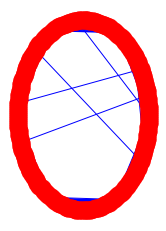

In [314]:
# using https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.generators.community.relaxed_caveman_graph.html
g = nx.relaxed_caveman_graph(6, 25, 0.01, seed=42) # 6 cliques, size for each clique is 25, Probabilty of rewiring each edge.
hc_nodes = nx.harmonic_centrality(g) # using Boldi, Paolo, and Sebastiano Vigna. “Axioms for centrality.” Internet Mathematics 10.3-4 (2014): 222-262.
# Harmonic centrality 1 of a node u is the sum of the reciprocal of the shortest path distances from all other nodes to u
nx.set_node_attributes(g, hc_nodes, 'harmonic_centrality')
nx.write_graphml(g, "isolator_communities.graphml")  
plt.subplot(121)
nx.draw(g, pos=nx.circular_layout(g), node_color='r', edge_color='b')

In [315]:
# now determine modularity using iGraph
g = igraph.Graph.Read_GraphML("isolator_communities.graphml")
#g.summary()

# compute community detection using iGraph
community = g.community_multilevel() # using Louvain method (https://en.wikipedia.org/wiki/Louvain_modularity), VD Blondel, J-L Guillaume, R Lambiotte and E Lefebvre: Fast unfolding of community hierarchies in large networks, J Stat Mech P10008 (2008), http://arxiv.org/abs/0803.0476
#community 

#print(community)

# assign modularity class
g.vs['community_membership'] = 0 # default

g.vs['cultural_orientation'] = "" # default 


### For isolative community, proportions should be:
#LINKER (connector) - 10 % 2 nodes
#ENGAGER(interactor) - 30 % 8 nodes
#DIVIDER (divider) - 40 % 10 nodes
#LONER (avoider) - 20 % 5 nodes


comm_id= 0 # start with community 0
for comm in community: # iterate through communities to determine membership
    for node_id in comm:
        g.vs[node_id]['community_membership'] = comm_id
    comm_id+=1

connector_counts = []
interactor_counts = []
divider_counts = []
isolator_counts = []

####### Perhaps leave this for now with pure types
## Randomly select a community to be a gated community, where there are only two ways in
#gated_community = randint(len(community))
# first, will take a survey of all linker ties, and then only keep 2 of them

comm_id= 0 # start with community 0
# iterate through communities to rewire for isolates and divider
for comm in community: #[community[0]]: # iterate through communities 
    #print("\n\ncommunity:", comm_id)
    #print("first pass, linkers")    
    ########################
    ## first pass, creating connectors/linkers nodes
    ########################    
    potential_connector_nodes = []
    # these are defined as having connections to other clusters
    for node_id in comm:
        for neighbor_node in g.vs[node_id].neighbors(): 
            if neighbor_node['community_membership'] is not comm_id:
                potential_connector_nodes.append(node_id)
                g.vs[node_id]['cultural_orientation'] = "LINKER"
                break        
                #more ties out than in 
    connector_counts.append(len(potential_connector_nodes))    
    # process these nodes
    for node_id in potential_connector_nodes:
        desired_ties_into_clique = randint(2,4)
        # reduce edges
        possible_edges_to_prune = []
        for neighbor_node in g.vs[node_id].neighbors(): 
            if neighbor_node['community_membership'] is comm_id: possible_edges_to_prune.append( g.get_eid(node_id,neighbor_node.index) )
        # prune edges
        edges_to_prune = list(np.random.permutation(possible_edges_to_prune))[desired_ties_into_clique:]
        g.delete_edges(edges_to_prune)

    
    ########################
    ## second pass, creating interactor/engager nodes
    ########################    
    #print("second pass, engagers")
    potential_interactor_nodes = [node_id for node_id in comm if g.vs[node_id]['cultural_orientation'] is ""]
    #number_of_nodes_for_interactors_in_cluster = 10 # determine this based on nodes left over after next two passes
    # rewire random nodes to be isolates in isolate communities (could also be in a range)
    for node_id in potential_interactor_nodes:
        random_number_of_ties_to_keep = randint(3, 10) # this is condition for interactor nodes; remember this doesn't include ties to connectors            
        # reduce edges
        possible_edges_to_prune = []
        for neighbor_node in g.vs[node_id].neighbors():
            if neighbor_node['community_membership'] is comm_id and neighbor_node['cultural_orientation'] is not "LINKER": # only rewire ties to other null nodes
                possible_edges_to_prune.append( g.get_eid(node_id,neighbor_node.index) )
                # prune edges
        edges_to_prune = list(np.random.permutation(possible_edges_to_prune))[random_number_of_ties_to_keep:]                
        g.delete_edges(edges_to_prune)
        g.vs[node_id]['cultural_orientation'] = "ENGAGER"
    
    ########################
    ## third pass, creating isolator/loner nodes
    ########################    
       
    #print("third pass, loners")
    # turn some dividers nodes into loner nodes
    potential_isolator_nodes = [node_id for node_id in comm if g.degree(node_id) > 2 and g.vs[node_id]['cultural_orientation'] is "ENGAGER"]
    make_isolator_nodes = np.random.permutation(potential_isolator_nodes) # roll the dice
    number_of_nodes_for_isolators_in_cluster = 5 
    num_nodes_allocated = 0
    # check to see if there are already loners in this cluster
    for node_id in comm:
        if g.vs[node_id]['cultural_orientation'] is "ENGAGER" and g.degree(node_id)==1: 
            num_nodes_allocated+=1    
            g.vs[node_id]['cultural_orientation'] is "LONER"
    i=0
    while num_nodes_allocated < number_of_nodes_for_isolators_in_cluster:
        #print ("num_nodes_allocated:", num_nodes_allocated)        
        node_id = make_isolator_nodes[i] # select first one from the list
        connected_to_linker = False # default
        for neighbor_node in g.vs[node_id].neighbors():
            if neighbor_node['cultural_orientation'] is "LINKER": 
                connected_to_linker=True
                break
        if g.degree(node_id)>1 and connected_to_linker==False:        
            number_of_ties_to_keep = 1
            # try to reduce edges
            possible_edges_to_prune = []
            for neighbor_node in g.vs[node_id].neighbors():
                if neighbor_node['cultural_orientation'] is not "LINKER" and g.degree(neighbor_node.index)>1: # only rewire certain ties
                    possible_edges_to_prune.append( g.get_eid(node_id,neighbor_node.index) )
            # prune edges
            #print ("disconnecting node", node_id)
            edges_to_prune = list(np.random.permutation(possible_edges_to_prune))[number_of_ties_to_keep:]                            
            g.delete_edges(edges_to_prune)
            g.vs[node_id]['cultural_orientation'] = "LONER"
            num_nodes_allocated+=1 
        i+=1
      
    
    ########################
    ## fourth pass, creating divider nodes; defined as degree=2, tertius gaudens
    ########################    
    #print("fourth pass, dividers")
    potential_divider_nodes = [node_id for node_id in comm if g.vs[node_id]['cultural_orientation'] is "ENGAGER" and g.degree(node_id)>1]    
    #print ("len(potential_divider_nodes)=",len(potential_divider_nodes) )
    number_of_nodes_for_dividers_in_cluster = 10
    make_divider_nodes = np.random.permutation(potential_divider_nodes)
    nodes_allocated = 0
    for node_id in make_divider_nodes:
        # check for suitability of node to make divider
        node_suitable_flag = True # default
        #         for neighbor_node in g.vs[node_id].neighbors():
        #             if neighbor_node['cultural_orientation'] is not "ENGAGER":
        #                 node_suitable_flag=False
        #                 break
        if node_suitable_flag==True:        
            g.vs[node_id]['cultural_orientation'] = "DIVIDER"
            number_of_ties_to_keep = 2 # this is one condition for divider nodes
            # try to reduce edges
            possible_edges_to_prune = []
            for neighbor_node in g.vs[node_id].neighbors():
                if neighbor_node['cultural_orientation'] is "ENGAGER" and g.degree(neighbor_node.index)>1: # only rewire certain ties
                    possible_edges_to_prune.append( g.get_eid(node_id,neighbor_node.index) )
            # prune edges
            #print ("disconnecting node", node_id)
            edges_to_prune = list(np.random.permutation(possible_edges_to_prune))[number_of_ties_to_keep:]                            
            g.delete_edges(edges_to_prune)
            nodes_allocated+=1
            # now, implement tertius gaudens
            alters= g.vs[node_id].neighbors() # there should only be two
            if len(alters)>=2:
                if g.are_connected(alters[0].index, alters[1].index) and g.degree(alters[0].index)>1 and g.degree(alters[1].index)>1:
                    g.delete_edges(alters[0].index, alters[1].index)        

        if nodes_allocated== number_of_nodes_for_dividers_in_cluster: break
            
    for node_id in comm: 
        if g.degree(node_id)==1: g.vs[node_id]['cultural_orientation'] = "LONER"
    
    comm_id+=1

# resave graph                
g.write_graphml("isolator_communities_rewired.graphml")

### Distribute Cultural Orientations in the Networks


---
Distribute <br>
INTERACTOR, CONNECTOR, DIVIDER, AVOIDER, INTERACTOR_SW, CONNECTOR_SW
---

In [104]:
g1 = igraph.Graph.Read_GraphML("interactive_communities_rewired.graphml")
g1.summary()

'IGRAPH U--- 150 247 -- \n+ attr: community_membership (v), cultural_orientation (v), harmonic_centrality (v), id (v)'

In [105]:
for v in g1.vs:
    if v['cultural_orientation']=="LINKER": v['cultural_orientation']=CulturalOrientation.INTERACTOR.value
    elif v['cultural_orientation']=="ENGAGER": v['cultural_orientation']=CulturalOrientation.CONNECTOR.value
    elif v['cultural_orientation']=="DIVIDER": v['cultural_orientation']=CulturalOrientation.DIVIDER.value
    elif v['cultural_orientation']=="LONER": v['cultural_orientation']=CulturalOrientation.AVOIDER.value

In [106]:
g2 = igraph.Graph.Read_GraphML("isolator_communities_rewired.graphml")
g2.summary()

'IGRAPH U--- 150 196 -- \n+ attr: community_membership (v), cultural_orientation (v), harmonic_centrality (v), id (v)'

In [107]:
for v in g2.vs:
    if v['cultural_orientation']=="LINKER": v['cultural_orientation']=CulturalOrientation.INTERACTOR.value
    elif v['cultural_orientation']=="ENGAGER": v['cultural_orientation']=CulturalOrientation.CONNECTOR.value
    elif v['cultural_orientation']=="DIVIDER": v['cultural_orientation']=CulturalOrientation.DIVIDER.value
    elif v['cultural_orientation']=="LONER": v['cultural_orientation']=CulturalOrientation.AVOIDER.value

### Set up first model

In [108]:
# attempting to use the SEIR model published by Verity et al (2020) in the Lancet (could also use study published by WHO on January 31)

#beta = . #beta ( β ): probability susceptible-infected contact results in a new exposure - also called the force of infection (covered by social structure)
gamma = .75 #gamma ( γ ): probability infected recovers (based on constant [hospital] or based on this table [sender-receiver] )
# will need to do a sensitivity analysis for gamma (high, med, low)
sigma = .9 #sigma ( σ ): probability exposed person becomes infected (covered by cultural orientation)
# will need to do a sensitivity analysis for sigma (high, med, low)
mu = .02 #mu ( μ ): death rate
#gain_resistance_chance

model_1 = SocialSetting(g1, initial_outbreak_size=2, sigma=sigma, gamma=gamma, mu=mu,  recovery_chance=0.75)
print ("day:",model_1.day, " number_infected:",number_infected(model_1), " number_susceptible:", number_susceptible(model_1))

day: 0  number_infected: 2  number_susceptible: 148


### Run first model for 60 days

In [109]:
model_1.run_model(60)

actor deceased 46
actor deceased 107
actor deceased 118
actor deceased 28
actor deceased 124
actor deceased 100
actor deceased 130
actor deceased 130
actor deceased 111
actor deceased 21
actor deceased 94
actor deceased 79
actor deceased 92
actor deceased 127


### Gather data from model

In [110]:
data_g1 = model_1.datacollector.get_model_vars_dataframe()

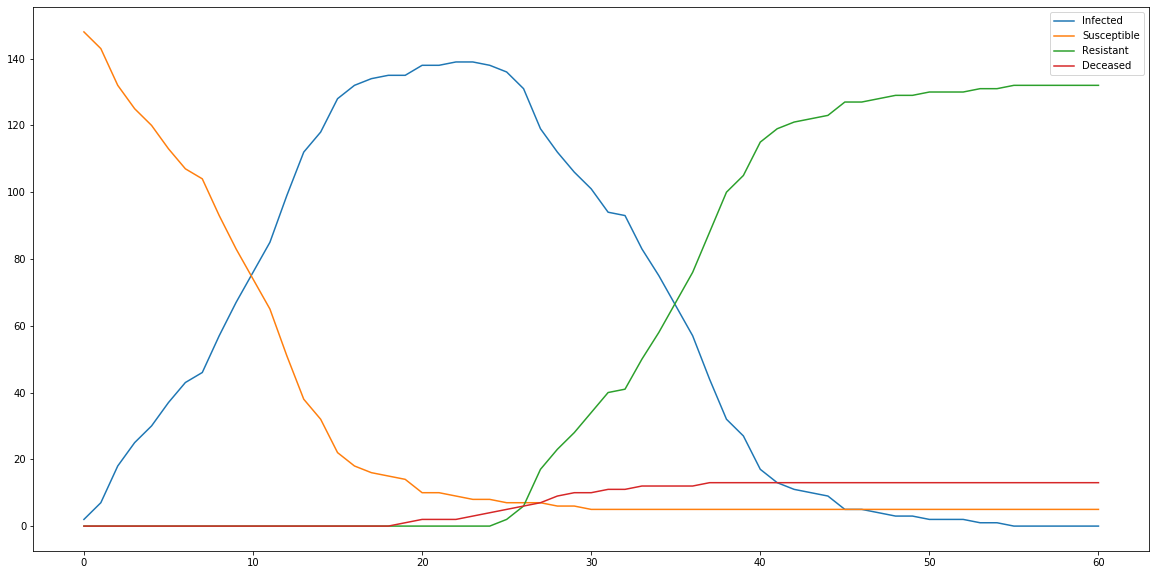

In [111]:
data_g1.plot(figsize=(20,10))

In [112]:
data_g1.head(60)

,Infected,Susceptible,Resistant,Deceased
0,2,148,0,0
1,7,143,0,0
2,18,132,0,0
3,25,125,0,0
4,30,120,0,0
5,37,113,0,0
6,43,107,0,0
7,46,104,0,0
8,57,93,0,0
9,67,83,0,0


### Create second model from Network

### Set up second model

In [113]:
# attempting to use the SEIR model published by Verity et al (2020) in the Lancet (could also use study published by WHO on January 31)

#beta = . #beta ( β ): probability susceptible-infected contact results in a new exposure - also called the force of infection (covered by social structure)
gamma = .75 #gamma ( γ ): probability infected recovers (based on constant [hospital] or based on this table [sender-receiver] )
# will need to do a sensitivity analysis for gamma (high, med, low)
sigma = .9 #sigma ( σ ): probability exposed person becomes infected (covered by cultural orientation)
# will need to do a sensitivity analysis for sigma (high, med, low)
mu = .02 #mu ( μ ): death rate
#gain_resistance_chance

model_2 = SocialSetting(g2, initial_outbreak_size=2, sigma=sigma, gamma=gamma, mu=mu,  recovery_chance=0.75)
print ("day:",model_2.day, " number_infected:",number_infected(model_2), " number_susceptible:", number_susceptible(model_2))

day: 0  number_infected: 2  number_susceptible: 148


### Run second model for 30 days

In [114]:
model_2.run_model(60)

actor deceased 6
actor deceased 23
actor deceased 71
actor deceased 66
actor deceased 56
actor deceased 50
actor deceased 131
actor deceased 48
actor deceased 31
actor deceased 86


### Gather data from model

In [115]:
data_g2 = model_2.datacollector.get_model_vars_dataframe()

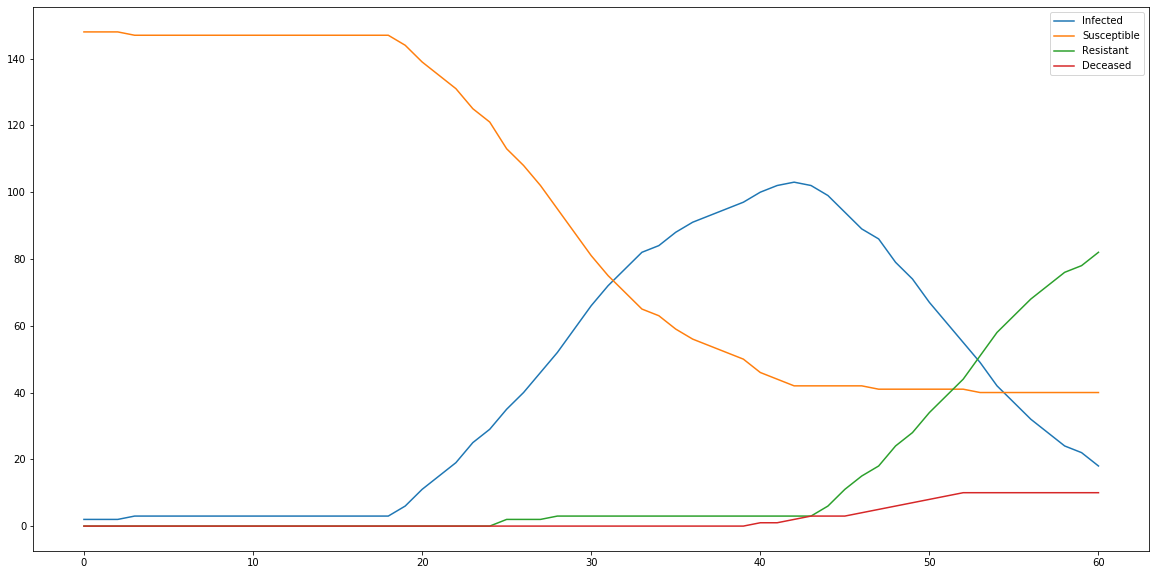

In [116]:
data_g2.plot(figsize=(20,10))

In [117]:
data_g2.head(60)

,Infected,Susceptible,Resistant,Deceased
0,2,148,0,0
1,2,148,0,0
2,2,148,0,0
3,3,147,0,0
4,3,147,0,0
5,3,147,0,0
6,3,147,0,0
7,3,147,0,0
8,3,147,0,0
9,3,147,0,0


###  Combine data from both models

In [118]:
data_combined = pd.concat([data_g1['Infected'],data_g2['Infected']], axis=1, keys=['Infections_Interactive_Community', 'Infections_Isolator_Community'])

In [119]:
data_combined.head(5)

,Infections_Interactive_Community,Infections_Isolator_Community
0,2,2
1,7,2
2,18,2
3,25,3
4,30,3


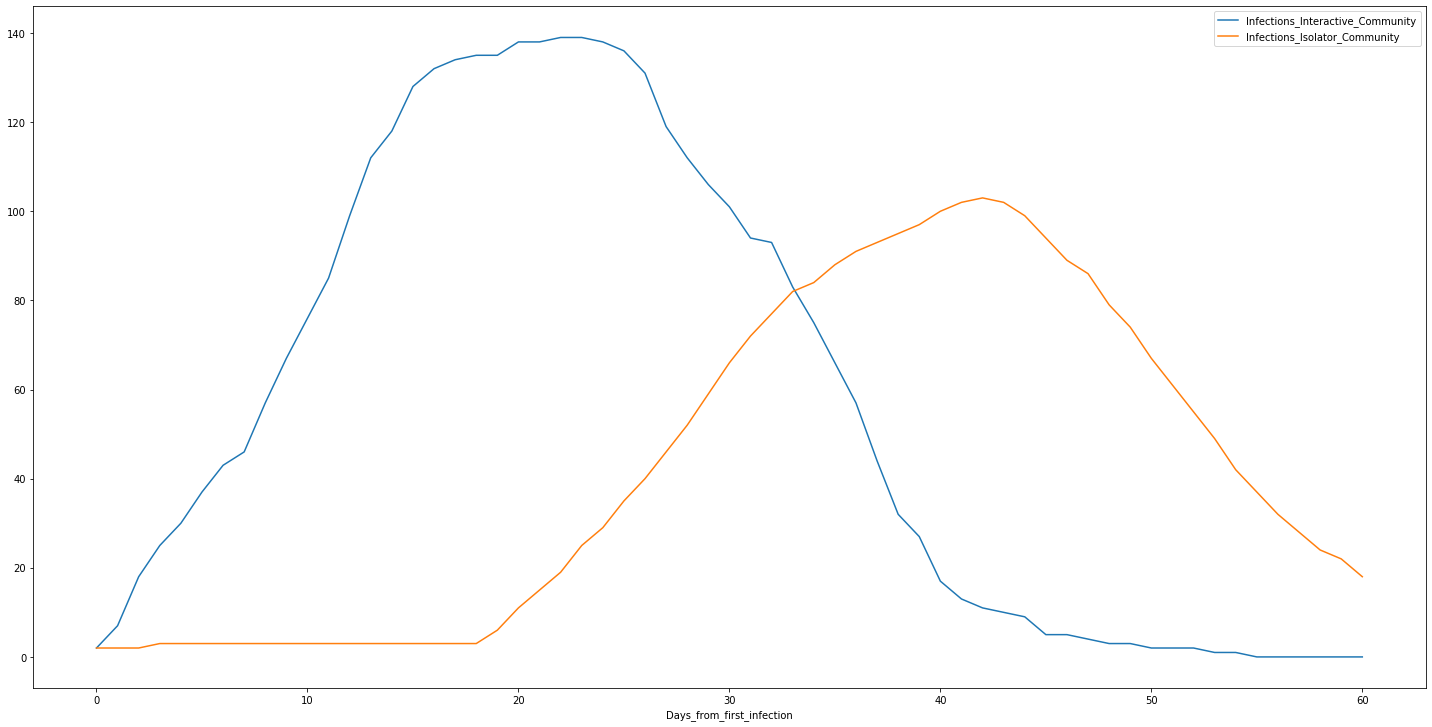

In [120]:
data_combined.plot(figsize=(20,10))
plt.tight_layout()
plt.xlabel('Days_from_first_infection')
plt.show()

## To do: 

-model a second wave by reconfiguring the network
-exporting snapshots of each graph in each step (standardized visualizations possible?)